In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from keras.utils import load_img
from keras.optimizers import Adam
from keras import Model
from skimage import measure
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate, Input, Dropout

In [3]:
!unzip /content/drive/MyDrive/building_footprint.zip

Archive:  /content/drive/MyDrive/building_footprint.zip
   creating: building_footprint/
   creating: building_footprint/images/
  inflating: building_footprint/images/global_monthly_2019_08_mosaic_L15-0331E-1257N_1327_3160_13.tif  
  inflating: building_footprint/images/global_monthly_2019_08_mosaic_L15-0357E-1223N_1429_3296_13.tif  
  inflating: building_footprint/images/global_monthly_2019_08_mosaic_L15-0358E-1220N_1433_3310_13.tif  
  inflating: building_footprint/images/global_monthly_2019_08_mosaic_L15-0361E-1300N_1446_2989_13.tif  
  inflating: building_footprint/images/global_monthly_2019_08_mosaic_L15-0368E-1245N_1474_3210_13.tif  
  inflating: building_footprint/images/global_monthly_2019_08_mosaic_L15-0387E-1276N_1549_3087_13.tif  
  inflating: building_footprint/images/global_monthly_2019_08_mosaic_L15-0434E-1218N_1736_3318_13.tif  
  inflating: building_footprint/images/global_monthly_2019_08_mosaic_L15-0487E-1246N_1950_3207_13.tif  
  inflating: building_footprint/images/

In [4]:
images = "/content/building_footprint/images"
masks = "/content/building_footprint/labels"
image_height = 256
image_width = 256
IMG_IDS = next(os.walk(images))[2]
#Storing all file names from DATA_IMAGES in IMG_IDS
print(f"No of images in the dataset: {len(IMG_IDS)}")

No of images in the dataset: 406


In [5]:
X = np.zeros((len(IMG_IDS), image_height, image_width, 1), dtype=np.float32)
y = np.zeros((len(IMG_IDS), image_height, image_width, 1), dtype=np.float32)
#X and y will be used to store the input images and masks respectively

In [6]:
'''def create_labelled_dataset():
   
    for n, ids in enumerate(IMG_IDS):        
        img = load_img(os.path.join(images, ids))
        x_img_arr = np.asarray((img))
        x_img = resize(x_img_arr, (image_height,image_width, 3), mode='constant', preserve_range=True)
        x_img = rgb2gray(x_img)
        x_img = np.expand_dims(x_img, axis=-1)
        
        mask  = load_img(os.path.join(masks, ids))
        y_mask_arr = np.asarray(mask)
        y_mask = resize(y_mask_arr, (image_height, image_width, 3), mode='constant', preserve_range=True)
        y_mask = rgb2gray(y_mask)
        y_mask = np.expand_dims(y_mask, axis=-1) 
        
        X[n] = x_img/255.0 
        y[n] = y_mask/255.0
        
    return X, y'''

"def create_labelled_dataset():\n   \n    for n, ids in enumerate(IMG_IDS):        \n        img = load_img(os.path.join(images, ids))\n        x_img_arr = np.asarray((img))\n        x_img = resize(x_img_arr, (image_height,image_width, 3), mode='constant', preserve_range=True)\n        x_img = rgb2gray(x_img)\n        x_img = np.expand_dims(x_img, axis=-1)\n        \n        mask  = load_img(os.path.join(masks, ids))\n        y_mask_arr = np.asarray(mask)\n        y_mask = resize(y_mask_arr, (image_height, image_width, 3), mode='constant', preserve_range=True)\n        y_mask = rgb2gray(y_mask)\n        y_mask = np.expand_dims(y_mask, axis=-1) \n        \n        X[n] = x_img/255.0 \n        y[n] = y_mask/255.0\n        \n    return X, y"

In [7]:
!pip install tifffile
!pip install imagecodecs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 43.7 MB/s eta 0:00:00


In [8]:
import imagecodecs
import tifffile

In [9]:
def create_labelled_dataset():
    for n, ids in enumerate(IMG_IDS):        
        img = tifffile.imread(os.path.join(images, ids))
        x_img_arr = np.asarray((img))
        x_img = resize(x_img_arr, (image_height,image_width, 3), mode='constant', preserve_range=True)
        x_img = rgb2gray(x_img)
        x_img = np.expand_dims(x_img, axis=-1)
        
        mask  = tifffile.imread(os.path.join(masks, ids))
        y_mask_arr = np.asarray(mask)
        y_mask = resize(y_mask_arr, (image_height, image_width, 3), mode='constant', preserve_range=True)
        y_mask = rgb2gray(y_mask)
        y_mask = np.expand_dims(y_mask, axis=-1) 
        
        X[n] = x_img/255.0 
        y[n] = y_mask/255.0
    return X, y

In [10]:
'''def create_labelled_dataset():

    for n, img_filename in enumerate(IMG_IDS):
        img = tifffile.imread(os.path.join(images, img_filename))
        x_img_arr = np.asarray(img)
        x_img = resize(x_img_arr, (image_height,image_width, 3), mode='constant', preserve_range=True)
        x_img = rgb2gray(x_img)
        x_img = np.expand_dims(x_img, axis=-1)
        
        mask_filename_prefix = os.path.splitext(img_filename)[0] 
        mask_filenames = [f for f in os.listdir(masks) if f.startswith(mask_filename_prefix)] 
        mask_filename = mask_filenames[0] 
        
        mask = tifffile.imread(os.path.join(masks, mask_filename))
        y_mask_arr = np.asarray(mask)
        y_mask = resize(y_mask_arr, (image_height, image_width, 3), mode='constant', preserve_range=True)
        y_mask = rgb2gray(y_mask)
        y_mask = np.expand_dims(y_mask, axis=-1) 
        
        X[n] = x_img/255.0 
        y[n] = y_mask/255.0
        
    return X, y'''

"def create_labelled_dataset():\n\n    for n, img_filename in enumerate(IMG_IDS):\n        img = tifffile.imread(os.path.join(images, img_filename))\n        x_img_arr = np.asarray(img)\n        x_img = resize(x_img_arr, (image_height,image_width, 3), mode='constant', preserve_range=True)\n        x_img = rgb2gray(x_img)\n        x_img = np.expand_dims(x_img, axis=-1)\n        \n        mask_filename_prefix = os.path.splitext(img_filename)[0] \n        mask_filenames = [f for f in os.listdir(masks) if f.startswith(mask_filename_prefix)] \n        mask_filename = mask_filenames[0] \n        \n        mask = tifffile.imread(os.path.join(masks, mask_filename))\n        y_mask_arr = np.asarray(mask)\n        y_mask = resize(y_mask_arr, (image_height, image_width, 3), mode='constant', preserve_range=True)\n        y_mask = rgb2gray(y_mask)\n        y_mask = np.expand_dims(y_mask, axis=-1) \n        \n        X[n] = x_img/255.0 \n        y[n] = y_mask/255.0\n        \n    return X, y"

In [11]:
X, y = create_labelled_dataset()

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(365, 256, 256, 1)
(365, 256, 256, 1)
(41, 256, 256, 1)
(41, 256, 256, 1)


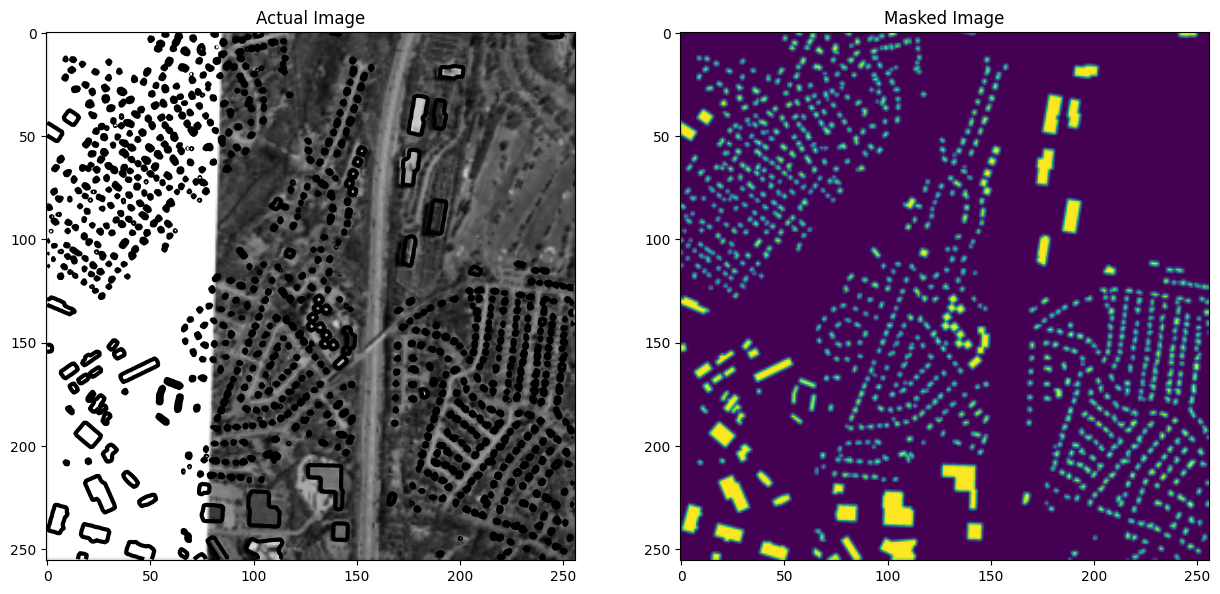

In [14]:
def plot_sample_examplee(ix):
    has_mask = y_train[ix].max() > 0

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 10))

    ax1.imshow(X_train[ix], cmap='gray', interpolation = 'bilinear')

    ax1.contour(y_train[ix].squeeze(), colors = 'black', linewidths = 3, levels = [0.5])
    ax1.set_title('Actual Image')

    ax2.imshow(y_train[ix].squeeze(), interpolation = 'bilinear')
    ax2.set_title('Masked Image')

plot_sample_examplee(25)

In [15]:
def Conv2D_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), \
              kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), \
               kernel_initializer='he_normal', padding='same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [16]:
def unet(input_image, n_filters=16, kernel_size=3, dropout=0.1, batchnorm=True):
    #Encoder
    c1 = Conv2D_block(input_image, n_filters, kernel_size = kernel_size, batchnorm = batchnorm)
    p1 = MaxPooling2D((2,2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = Conv2D_block(p1, n_filters * 2, kernel_size = kernel_size, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = Conv2D_block(p2, n_filters * 4, kernel_size = kernel_size, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = Conv2D_block(p3, n_filters * 8, kernel_size = kernel_size, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = Conv2D_block(p4, n_filters * 16, kernel_size = kernel_size, batchnorm = batchnorm)
    
    # Decoder
    u6 = Conv2DTranspose(n_filters * 8, (kernel_size, kernel_size), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = Conv2D_block(u6, n_filters * 8, kernel_size = kernel_size, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (kernel_size, kernel_size), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = Conv2D_block(u7, n_filters * 4, kernel_size = kernel_size, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (kernel_size, kernel_size), strides=(2,2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = Conv2D_block(u8, n_filters * 2, kernel_size = kernel_size, batchnorm = batchnorm)
   
    u9 = Conv2DTranspose(n_filters, (kernel_size, kernel_size), strides=(2,2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = Conv2D_block(u9, n_filters, kernel_size = kernel_size, batchnorm = batchnorm)
   
    output = Conv2D(1, (1,1), activation='sigmoid')(c9)
    model = Model(inputs=[input_image], outputs=[output])
    return model

In [17]:
input_img = Input((image_height, image_width, 1), name='img')

In [18]:
model = unet(input_img, n_filters=16, kernel_size=3, dropout=0.01, batchnorm=True)

In [19]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["accuracy"])

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [21]:
history = model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_valid, y_valid))

Epoch 1/100
23/23 [==============================] - 35s 574ms/step - loss: 0.5779 - accuracy: 0.4581 - val_loss: 2.4569 - val_accuracy: 0.0578
Epoch 2/100
23/23 [==============================] - 6s 241ms/step - loss: 0.4082 - accuracy: 0.5274 - val_loss: 101.8133 - val_accuracy: 0.0375
Epoch 3/100
23/23 [==============================] - 6s 244ms/step - loss: 0.3647 - accuracy: 0.5296 - val_loss: 5.1194 - val_accuracy: 0.2567
Epoch 4/100
23/23 [==============================] - 6s 244ms/step - loss: 0.3480 - accuracy: 0.5297 - val_loss: 0.4460 - val_accuracy: 0.4735
Epoch 5/100
23/23 [==============================] - 6s 246ms/step - loss: 0.3352 - accuracy: 0.5300 - val_loss: 0.3998 - val_accuracy: 0.4757
Epoch 6/100
23/23 [==============================] - 6s 246ms/step - loss: 0.3276 - accuracy: 0.5301 - val_loss: 0.3820 - val_accuracy: 0.4761
Epoch 7/100
23/23 [==============================] - 6s 246ms/step - loss: 0.3196 - accuracy: 0.5304 - val_loss: 0.3895 - val_accuracy: 0.4

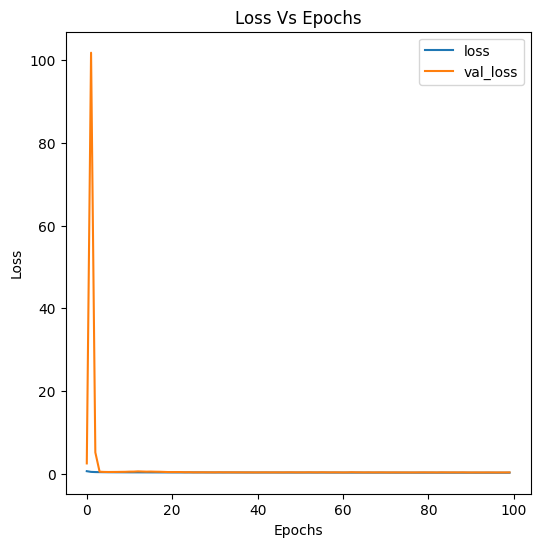

In [22]:
def plot_history(results):
    plt.figure(figsize=(6,6))
    plt.title("Loss Vs Epochs")
    plt.plot(results.history["loss"], label="loss")
    plt.plot(results.history["val_loss"], label="val_loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

plot_history(history)

In [23]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

2/2 [==============================] - 0s 89ms/step


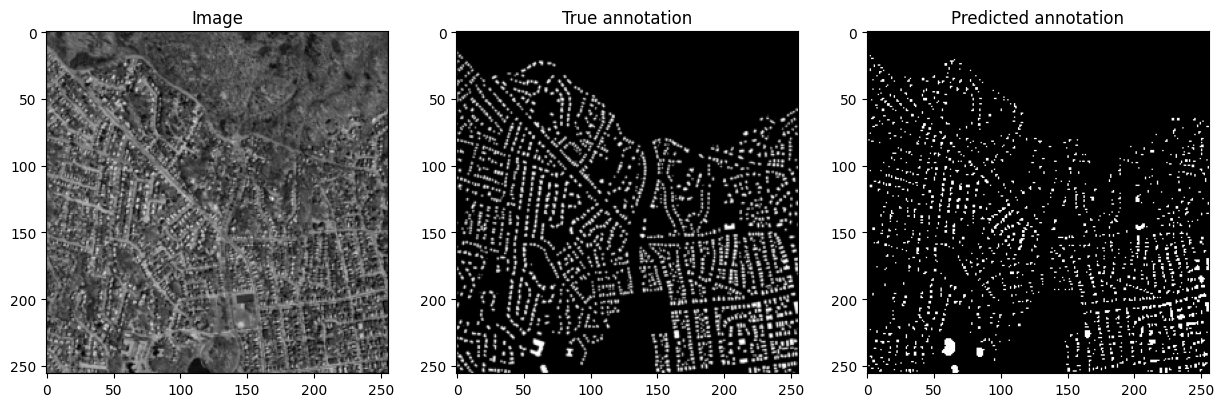

In [24]:
def plot_sample_resultt(X, y, binary_preds, ix):
    fig, ax = plt.subplots(1, 3, figsize=(15,7))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')

    ax[0].set_title('Image')
    
    ax[1].imshow(y[ix], cmap='gray')
    ax[1].set_title('True annotation')
    
    ax[2].imshow(binary_preds[ix].squeeze(), cmap='gray',vmin=0, vmax=1)
    ax[2].set_title('Predicted annotation')
plot_sample_resultt(X_train, y_train, preds_train_t,55)

In [25]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('/content/drive/MyDrive/tilotama2.png')

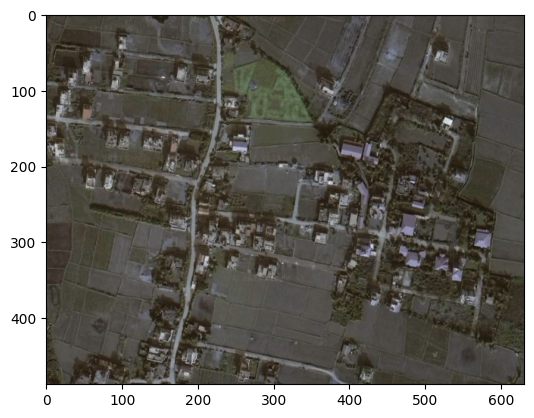

In [26]:
plt.imshow(img)

1/1 [==============================] - 0s 33ms/step


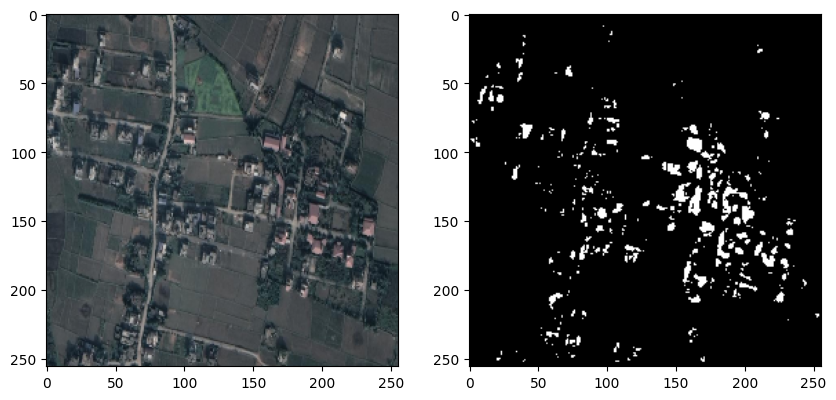

In [28]:
test_image_resized = cv2.resize(img, (image_height, image_width))
test_image_gray = cv2.cvtColor(test_image_resized, cv2.COLOR_BGR2GRAY)
test_image_normalized = test_image_gray / 255.0
test_image_input = np.expand_dims(test_image_normalized, axis=-1)
test_image_input = np.expand_dims(test_image_input, axis=0)

predicted_mask = model.predict(test_image_input)

predicted_mask = predicted_mask.reshape(image_height, image_width)
predicted_mask_binary = np.where(predicted_mask > 0.5, 1, 0)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv2.cvtColor(test_image_resized,cv2.COLOR_BGR2RGB))
ax[1].imshow(predicted_mask_binary,interpolation='bilinear',cmap='gray')
plt.show()

In [29]:
model.save('my_model.pb')

In [31]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content/my_model.pb')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

In [32]:
print("Quantized model size:", len(tflite_quant_model), "bytes")

Quantized model size: 2204736 bytes


In [33]:
size_in_kb = 2204632 / 1024
print("Quantized model size:", size_in_kb, "KB")

Quantized model size: 2152.9609375 KB


In [34]:
size_in_mb= 2152.96 / 1024
print("Quantized model size:", size_in_mb, "MB")

Quantized model size: 2.1025 MB
